In [1]:
import gensim
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [4]:
""" Adapted from https://weiliu2k.github.io/CITS4012/embeddings/svd.html#using-svd-to-reduce-to-k-dim

"""
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
        # ------------------
        # Write your implementation here.
    M_r = sklearn.decomposition.TruncatedSVD(n_components=k,
                                            algorithm='randomized', 
                                            n_iter=n_iters, 
                                            random_state=None, 
                                            tol=0.0)
    M_reduced = M_r.fit_transform(M)
        # ------------------

    print("Done.")
    return M_reduced

In [5]:
# Read raw data, select 2 classes and random select 50 data point from each class
ag_raw = pd.read_csv('../datasets/train.csv',usecols = ['Label','Title'])
ag_1_raw = ag_raw.loc[(ag_raw['Label']== 4) | (ag_raw['Label']== 3)]
ag_23 = ag_1_raw.groupby('Label').apply(lambda x: x.sample(50,random_state=2))
ag_23["Label"].value_counts()

3    50
4    50
Name: Label, dtype: int64

In [6]:
# Convert class value 3 and 4 to 0 and 1
ag_label_lst_raw = ag_23['Label'].to_list()  
ag_label_lst = []
for l in ag_label_lst_raw:
    if l == 3:
        ag_label_lst.append(0)
    else:
        ag_label_lst.append(1)

ag_label = np.array(ag_label_lst)

In [7]:
# Tokenization
title_list = []
for i in range(len(ag_23)):
    doc  = nlp(ag_23.iloc[i,1])
    sent = []
    for token in doc:
        if not token.is_punct and not token.is_stop and token.is_alpha:
            if token.ent_type == 0:
                sent.append(token.text.lower())
            else:
                sent.append(token.text)
    title_list.append(sent)

In [8]:
# Vocab
all_token = [ token for lst in title_list for token in lst]
all_token = list(set(all_token))

In [9]:
# Match word embeddings and remove word from vocab that doesn't have embedding in pre-trained model
token_vector   = [wv[token] for token in all_token if token in wv.index_to_key]
filtered_token = [token for token in all_token if token in wv.index_to_key]

In [10]:
# Insert an empty token
filtered_token.insert(0,'')

In [11]:
len(all_token),len(token_vector),len(filtered_token)

(459, 453, 454)

In [12]:
# Insert full zero embedding for empty token
allzero = np.zeros((300),dtype=np.float32)
token_vector.insert(0,allzero)
embeddings= np.array(token_vector)

In [13]:
# training_sent = []
# for title in title_list:
#     sent = ''
#     for word in title:
#         sent += word + ' '
#     sentence = sent[:-1]
#     training_sent.append(sentence)

In [15]:
# Remove word that doesn't have embedding in word2vec
for sent in title_list:
    for word in sent:
        if word  not in filtered_token:
            sent.remove(word)

In [16]:
# check if any word not exist in word2vec embedding
for sent in title_list:
    for word in sent:
        if word  not in filtered_token:
            print(word,'not exist','from',sent)

In [17]:
vocab = dict(zip(filtered_token, range(len(filtered_token))))

In [18]:
class_names=['Business','Sci/Tech']

------------


In [19]:
# Match word to id
sent_wordid = []
for sent in title_list:
    wordid  = []
    for word in sent:
        wordid.append(vocab.get(word))
    sent_wordid.append(wordid)

In [20]:
# Fill each sentence size to 200
for sent in sent_wordid:
    length = 200 - len(sent)
    sent += length * [0]

In [21]:
x_raw = np.array(sent_wordid)

In [22]:
x_train,x_test, y_train,y_test = train_test_split(x_raw,ag_label, test_size = 0.3, random_state=42)

In [23]:
from tensorflow.keras.layers import Embedding

num_tokens = len(vocab)
embedding_dim = 300

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embeddings),   # Pass in embedding matrix
    trainable=False,
)

In [24]:
from tensorflow.keras import layers

# Construct textCNN model
fz = 128
ker =5

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(fz, ker, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(fz, ker, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(fz, ker, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(fz, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         136200    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                         

In [25]:
# Same Optimizer as VQC with same learning rate and nesterov momentum 
opt = tf.keras.optimizers.SGD(learning_rate=0.05,momentum=0.9,nesterov=True)  

In [24]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=["acc"]
)
ag_news = model.fit(x_train, y_train, batch_size=70, epochs=80, validation_data=(x_test, y_test))

Epoch 1/80
2/2 [==============================] - 15s 2s/step - loss: 0.2501 - acc: 0.4286 - val_loss: 0.2501 - val_acc: 0.5333
Epoch 2/80
2/2 [==============================] - 0s 29ms/step - loss: 0.2501 - acc: 0.4667 - val_loss: 0.2500 - val_acc: 0.4889
Epoch 3/80
2/2 [==============================] - 0s 29ms/step - loss: 0.2501 - acc: 0.4762 - val_loss: 0.2500 - val_acc: 0.4667
Epoch 4/80
2/2 [==============================] - 0s 26ms/step - loss: 0.2501 - acc: 0.4000 - val_loss: 0.2500 - val_acc: 0.5111
Epoch 5/80
2/2 [==============================] - 0s 28ms/step - loss: 0.2501 - acc: 0.3429 - val_loss: 0.2500 - val_acc: 0.4889
Epoch 6/80
2/2 [==============================] - 0s 28ms/step - loss: 0.2501 - acc: 0.4286 - val_loss: 0.2500 - val_acc: 0.4667
Epoch 7/80
2/2 [==============================] - 0s 31ms/step - loss: 0.2501 - acc: 0.4190 - val_loss: 0.2500 - val_acc: 0.4444
Epoch 8/80
2/2 [==============================] - 0s 33ms/step - loss: 0.2501 - acc: 0.5524 - val_

In [ ]:
import matplotlib.pyplot as plt

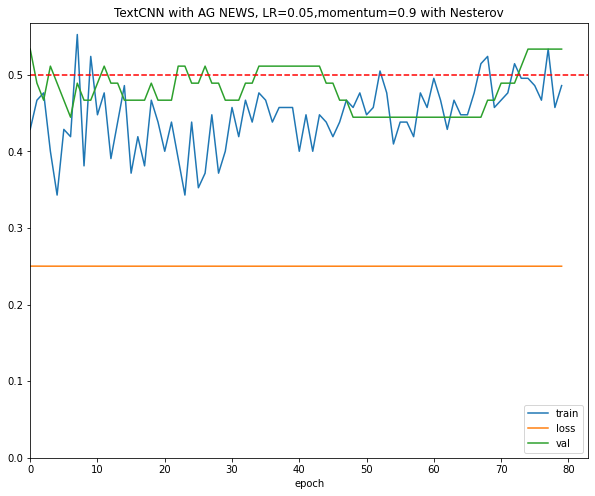

In [44]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(ag_news.history['acc'])
plt.plot(ag_news.history['loss'])
plt.plot(ag_news.history['val_acc'])
plt.xlabel('epoch')
plt.legend(['train','loss', 'val'], loc='lower right')
plt.title('TextCNN with AG NEWS, LR=0.05,momentum=0.9 with Nesterov')
plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0)
plt.axhline(y=0.5,color='r',ls='dashed')

plt.show()